# Analisis Dataset Airbnb Singapura (28/9/2025-2026)
## A. Pendahuluan
### 1. Deskripsi Dataset:
Dataset yang digunakan dalam analisis ini bersumber dari Inside Airbnb, yang mencakup data publik mengenai aktivitas penyewaan akomodasi di Singapura dengan cakupan waktu hingga tahun 2026. Dataset ini terdiri dari empat komponen utama yang saling terintegrasi:
- Listings Data: Berisi detail properti seperti koordinat geografis (latitude/longitude), harga per malam, jenis ruangan, jumlah kamar, serta informasi mengenai host (tuan rumah).
- Reviews Data: Kumpulan ulasan tekstual dari tamu yang memberikan gambaran mengenai pengalaman pengguna dan tingkat popularitas sebuah unit.
- Calendar Data: Data dinamis yang mencatat ketersediaan unit dan fluktuasi harga harian di masa depan, yang sangat krusial untuk analisis tren temporal.
- Neighbourhoods GeoJSON: Data spasial yang mendefinisikan batas-batas wilayah (districts) di Singapura untuk keperluan pemetaan geografis.
### 2. Alasan Dataset Menarik:
- Karakteristik Pasar Urban yang Padat: Singapura adalah negara kota dengan keterbatasan lahan dan regulasi properti yang sangat ketat. Dataset ini menarik untuk melihat bagaimana ekonomi berbagi bertahan di tengah keterbatasan ruang dan hukum yang kaku.
- Sensitivitas terhadap Event Global: Sebagai hub utama di Asia Tenggara, Singapura menjadi tuan rumah bagi acara internasional seperti F1 Grand Prix. Dataset ini memberikan kesempatan langka untuk menganalisis fenomena supply shock—bagaimana harga bereaksi ketika permintaan melonjak drastis dalam waktu singkat.
- Kekayaan Data Spasial & Temporal: Jarang sekali ditemukan dataset yang menyediakan kombinasi detail lokasi sekaligus prediksi harga di masa depan hingga tahun depan (2026), menjadikannya laboratorium yang ideal untuk simulasi strategi bisnis akomodasi.
### 3. Tujuan Analisis:
- Optimalisasi Nilai (Keuntungan): Bagaimana cara mendeteksi unit akomodasi yang menawarkan keseimbangan terbaik antara harga dan kualitas ulasan bagi wisatawan?
- Identifikasi Segmen Pasar: Bagaimana karakteristik dan persebaran geografis dari unit-unit yang masuk dalam kategori elit (Premium Gems) dibandingkan dengan unit yang ramah anggaran (Hidden Values)?
- Analisis Dampak Kelangkaan (Scarcity Analysis): Sejauh mana pengaruh event-event besar (F1, Libur Akhir Tahun, Imlek) terhadap penipisan suplai unit dan lonjakan harga di pasar?
- Pemetaan Momentum Pertumbuhan: Di wilayah mana saja terjadi pertumbuhan permintaan tercepat (review velocity) yang bisa menjadi indikasi area investasi baru di masa depan?

## B. Setup & Package
### 1. Import library & penyeseuaian lingkungan notebook

Pada sel berikut saya impor library yang akan digunakan dan melakukan penyesuaian terhadap notebook saya.

In [31]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")

### 2. Penyimpanan `PATH` file

In [32]:
raw_path = {
    'calendar.gz' : '../data/raw/calendar.csv.gz',
    'listings' : '../data/raw/listings.csv',
    'listings.gz' : '../data/raw/listings.csv.gz',
    'neighbourhoods' : '../data/raw/neighbourhoods.csv',
    'neighbourhoods.geo' : '../data/raw/neighbourhoods.geojson',
    'reviews' : '../data/raw/reviews.csv',
    'reviews.gz' : '../data/raw/reviews.csv.gz'
}

### 3. Penjelasan Fungsi Paket
- `pandas (pd)`: Untuk manipulasi data tabel, merging dataset, filtering.
- `numpy (np)`: Untuk operasi array yang bersifat statistik.
- `geopandas (gpd)`: Untuk data spasial, membaca data peta **geojson**, **shp**.
- `matplotlib.pyplot (plt)`: Visualisasi dasar untuk mengatur sumbu, struktur grafik, dan tata letak.
- `seaborn (sns)`: Berbasis matplotlib yang lebih estetik dan modern.
- `matplotlib.patches.Polygon` & `PatchCollection`:  Menggambar bentuk poligon wilayah/peta.
- `sklearn.preprocessing.MinMaxScaler1`: Untuk normalisasi data agar semua variabel bisa dibandingkan secara adil.

## C. Data Preparation
### 1. Baca dataset dari data yang ada sesuai **path**

In [33]:
calendar_gz = pd.read_csv(raw_path['calendar.gz'])

listings = pd.read_csv(raw_path['listings'])
listings_gz = pd.read_csv(raw_path['listings.gz'])

neighbourhoods = pd.read_csv(raw_path['neighbourhoods'])
neighbourhoods_geo = gpd.read_file(raw_path['neighbourhoods.geo'])

reviews = pd.read_csv(raw_path['reviews'])
reviews_gz = pd.read_csv(raw_path['reviews.gz'])

- Cek fragmen dataset yang duplikat!
    - `listings` dan `listings_gz`
    - `neighbourhoods` dan `neighbourhood_.geo`
    - `reviews` dan `reviews_gz`

In [34]:
print("5 Kolom Pertama listings:", listings.head())
print("5 Kolom Pertama listings_gz:", listings_gz.head())

5 Kolom Pertama listings:        id                                              name  host_id  \
0   71609               Ensuite Room (Room 1 & 2) near EXPO   367042   
1   71896                   B&B  Room 1 near Airport & EXPO   367042   
2   71903                        Room 2-near Airport & EXPO   367042   
3  275343  10min walk to MRT & a Cozy Room with window! (1)  1439258   
4  275344             15 mins to Outram MRT Single Room (2)  1439258   

  host_name neighbourhood_group neighbourhood  latitude  longitude  \
0   Belinda         East Region      Tampines   1.34537  103.95887   
1   Belinda         East Region      Tampines   1.34754  103.95958   
2   Belinda         East Region      Tampines   1.34531  103.96100   
3       Kay      Central Region   Bukit Merah   1.29015  103.80814   
4       Kay      Central Region   Bukit Merah   1.28836  103.81144   

      room_type  price  minimum_nights  number_of_reviews last_review  \
0  Private room    NaN              92         

In [35]:
print("5 Kolom Pertama neighbourhoods:", neighbourhoods.head())
print("5 Kolom Pertama neighbourhoods:", neighbourhoods_geo.head())

5 Kolom Pertama neighbourhoods:   neighbourhood_group  neighbourhood
0      Central Region         Bishan
1      Central Region    Bukit Merah
2      Central Region    Bukit Timah
3      Central Region  Downtown Core
4      Central Region        Geylang
5 Kolom Pertama neighbourhoods:    neighbourhood neighbourhood_group  \
0      Pasir Ris         East Region   
1        Seletar   North-East Region   
2   Sungei Kadut        North Region   
3        Orchard      Central Region   
4  Downtown Core      Central Region   

                                            geometry  
0  MULTIPOLYGON (((103.95322 1.38202, 103.9535 1....  
1  MULTIPOLYGON (((103.88691 1.42649, 103.88812 1...  
2  MULTIPOLYGON (((103.7644 1.44345, 103.76443 1....  
3  MULTIPOLYGON (((103.84298 1.30001, 103.84294 1...  
4  MULTIPOLYGON (((103.85942 1.29978, 103.85954 1...  


In [36]:
print("5 Kolom Pertama reviews:", reviews.head())
print("5 Kolom Pertama reviews_gz:", reviews_gz.head())

5 Kolom Pertama reviews:    listing_id        date
0       71609  2011-12-19
1       71609  2012-07-17
2       71609  2012-09-01
3       71609  2012-09-04
4       71609  2013-01-02
5 Kolom Pertama reviews_gz:    listing_id       id        date  reviewer_id reviewer_name  \
0       71609   793880  2011-12-19      1456140           Max   
1       71609  1731810  2012-07-17      1804182         Jaiya   
2       71609  2162194  2012-09-01      3113461         Zahra   
3       71609  2190615  2012-09-04      1432123        Helmut   
4       71609  3221837  2013-01-02      2759938          Jack   

                                            comments  
0  The rooms were clean and tidy. Beds very comfo...  
1  Good space and quite an interesting home in a ...  
2  It was a comfortable place. Belinda was a kind...  
3  We are four mature age travellers and stayed f...  
4  Belinda is a great host! She helps you wheneve...  


Saya akan mengambil fragmen dataset:
- `listings.csv.gz`, 
- `neighbourhoods.geojson`,
- `reviews.csv.gz`,

serta akan mengabaikan:
- `listings.csv`,
- `neighbourhoods.csv`,
- `reviews.csv`

karena fragmen-fragmen dataset tersebut merupakan duplikat dan tidak komplit (yang diabaikan) dari versi yang akan saya ambil.

### 2. Proses *Cleaning* dan *Data Wrangling*

- Pengecekan untuk fragmen dataset `listings_gz` atau `listings.csv.gz`:

In [37]:
print("Head & Tail dari listings_gz:\n", listings_gz.head(), "\n", listings_gz.tail())

Head & Tail dari listings_gz:
        id                          listing_url       scrape_id last_scraped  \
0   71609   https://www.airbnb.com/rooms/71609  20250928035118   2025-09-28   
1   71896   https://www.airbnb.com/rooms/71896  20250928035118   2025-09-28   
2   71903   https://www.airbnb.com/rooms/71903  20250928035118   2025-09-28   
3  275343  https://www.airbnb.com/rooms/275343  20250928035118   2025-09-28   
4  275344  https://www.airbnb.com/rooms/275344  20250928035118   2025-09-28   

            source                                              name  \
0  previous scrape               Ensuite Room (Room 1 & 2) near EXPO   
1      city scrape                   B&B  Room 1 near Airport & EXPO   
2      city scrape                        Room 2-near Airport & EXPO   
3  previous scrape  10min walk to MRT & a Cozy Room with window! (1)   
4  previous scrape             15 mins to Outram MRT Single Room (2)   

                                         description  \
0    

- Identifikasi fragmen dataset di atas:
    - Kolom `price` di Airbnb biasanya mengandung simbol mata uang ($) dan operator desimal (,).
    - Kolom `bathrooms_text` berisi data kotor (contoh: "1.5 baths"). Saya ingin mengekstrak angkanya.
    - Ada *missing values* pada kolom `bedrooms`, `beds`, dan `bathrooms`. Prosedur penanganannya adalah imputasi menggunakan median, karena jumlah kamar/tempat tidur biasanya memiliki *outlier*.
    - Ada *missing values* pada kolom `price`. Prosedur penanganannya adalah imputasi berdasar median wilayah.

In [38]:
# 1. Pembersihan kolom Price
listings_gz['price'] = listings_gz['price'].replace(r'[\$,]','',regex=True).astype(float)

# 2. Ekstrak angka dari kolom bathrooms_text
listings_gz['bathrooms_count'] = listings_gz['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)

# 3. Imputasi misval
listings_gz['bedrooms'] = listings_gz['bedrooms'].fillna(listings_gz['bedrooms'].median())
listings_gz['beds'] = listings_gz['beds'].fillna(listings_gz['beds'].median())
listings_gz['bathrooms_count'] = listings_gz['bathrooms_count'].fillna(listings_gz['bathrooms_count'].median())

# 4. Imputasi Harga berdasar median wilayah
listings_gz['price'] = listings_gz['price'].fillna(listings_gz.groupby('neighbourhood_cleansed')['price'].transform('median'))

- Standarisasi & Transformasi untuk fragmen dataset yang sama:
    - Harga Airbnb biasanya ada outlier (contoh: $10.000, kemungkinan salah ketik). Harus dibatasi batasan datanya.
    - Scaling data agar menyamakan skala fitur (*faeature engineering*).
    - Membuat **Host Seniority** agar `host_since` dapat diolah
    - Pengubahan biner untuk data 't' dan 'f' ke '1' dan '0'.

In [39]:
# 1. Handling Outlier
Q1 = listings_gz['price'].quantile(0.25)
Q3 = listings_gz['price'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
listings_gz['price_cleaned'] = listings_gz['price'].clip(0, upper_limit)

# 2. Scaling
scaler = MinMaxScaler()
listings_gz['price_scalendar_gzendar_gzendar_gzendar_gzed'] = scaler.fit_transform(listings_gz[['price_cleaned']])

# 3. Fitur "Host Seniority"
listings_gz['host_since'] = pd.to_datetime(listings_gz['host_since'])
listings_gz['host_seniority_years'] = 2025 - listings_gz['host_since'].dt.year

# 4. Binary Transformation
listings_gz['host_is_superhost'] = listings_gz['host_is_superhost'].map({'t': 1, 'f': 0}).fillna(0)

- Simpan fragmen dataset yang telah diolah.

In [40]:
df_clean = listings_gz.copy()

df_clean['price_cleaned'] = df_clean['price'].replace(r'[\$,]', '', regex=True).astype(float)
df_clean['price_cleaned'] = df_clean['price_cleaned'].fillna(df_clean.groupby('neighbourhood_cleansed')['price_cleaned'].transform('median'))

Q1, Q3 = df_clean['price_cleaned'].quantile(0.25), df_clean['price_cleaned'].quantile(0.75)
upper_limit = Q3 + 1.5 * (Q3 - Q1)
df_clean['price_cleaned'] = df_clean['price_cleaned'].clip(0, upper_limit)

scaler = MinMaxScaler()
df_clean['price_scaled'] = scaler.fit_transform(df_clean[['price_cleaned']])

df_clean['host_since'] = pd.to_datetime(df_clean['host_since'], errors='coerce')
df_clean['host_seniority_years'] = 2026 - df_clean['host_since'].dt.year
df_clean['host_seniority_years'] = df_clean['host_seniority_years'].fillna(0)

if 'bathrooms_text' in df_clean.columns:
    df_clean['bathrooms_count'] = df_clean['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float).fillna(0)
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].map({'t': 1, 'f': 0}).fillna(0)

columns_to_keep = [
    'id', 'name', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
    'latitude', 'longitude', 'room_type', 'price_cleaned', 'price_scaled',
    'bathrooms_count', 'bedrooms', 'beds', 'number_of_reviews', 
    'review_scores_rating', 'host_is_superhost', 'host_seniority_years'
]
listings_gz = df_clean[columns_to_keep].copy()

- Pengecekan untuk fragmen dataset `calendar_gz` atau `calendar.csv.gz`:

In [41]:
print("Head & Tail dari calendar_gz:\n", calendar_gz.head(), "\n", calendar_gz.tail())

Head & Tail dari calendar_gz:
    listing_id        date available  price  adjusted_price  minimum_nights  \
0    12434512  2025-09-28         f    NaN             NaN              90   
1    12434512  2025-09-29         f    NaN             NaN              90   
2    12434512  2025-09-30         f    NaN             NaN              90   
3    12434512  2025-10-01         f    NaN             NaN              90   
4    12434512  2025-10-02         f    NaN             NaN              90   

   maximum_nights  
0            1125  
1            1125  
2            1125  
3            1125  
4            1125   
          listing_id        date available  price  adjusted_price  \
1347940    22395492  2026-09-23         t    NaN             NaN   
1347941    22395492  2026-09-24         t    NaN             NaN   
1347942    22395492  2026-09-25         t    NaN             NaN   
1347943    22395492  2026-09-26         t    NaN             NaN   
1347944    22395492  2026-09-27       

- Identifikasi fragmen dataset di atas:
    - Transformasi `date` ke **datetime**.

In [42]:
calendar_gz['date'] = pd.to_datetime(calendar_gz['date'])

- Standarisasi & Transformasi untuk fragmen dataset yang sama:
    - Fitur Ekstraksi Temporal, data tunggal sulit dianalisis untuk pola besar. Dapat dipecah menjadi bulanan.
    - Sinkronisasi Harga dari listings karena banyak kolom NaN.
    - Perlu melihat gambaran besar dari harga tahun 2025-2026 dengan agregasi bulanan. Jika tidak, nanti data terlalu *noisy* karena perharian.

In [43]:
# 1. Enrichment: Fitur Waktu
calendar_gz['month'] = calendar_gz['date'].dt.month
calendar_gz['day_name'] = calendar_gz['date'].dt.day_name()
calendar_gz['is_weekend'] = calendar_gz['date'].dt.weekday.isin([5, 6]).astype(int)

# 2. Sinkronisasi Harga dari Listings
price_map = listings_gz.set_index('id')['price_cleaned'].to_dict()
calendar_gz['price_final'] = calendar_gz['listing_id'].map(price_map)

# 3. Rataan harga bulanan
monthly_trend = calendar_gz.groupby('month')['price_final'].mean().reset_index()

- Simpan fragmen dataset yang telah diolah.

In [44]:
calendar_gz = calendar_gz[calendar_gz['available'] == 't'].copy()
calendar_gz.to_csv('../data/processed/calendar_cleaned.csv', index=False)

- Pengecekan untuk fragmen dataset `reviews_gz` atau `reviews.csv.gz`:

In [45]:
print("Head & Tail dari reviews_gz:\n", reviews_gz.head(), "\n", reviews_gz.tail())

Head & Tail dari reviews_gz:
    listing_id       id        date  reviewer_id reviewer_name  \
0       71609   793880  2011-12-19      1456140           Max   
1       71609  1731810  2012-07-17      1804182         Jaiya   
2       71609  2162194  2012-09-01      3113461         Zahra   
3       71609  2190615  2012-09-04      1432123        Helmut   
4       71609  3221837  2013-01-02      2759938          Jack   

                                            comments  
0  The rooms were clean and tidy. Beds very comfo...  
1  Good space and quite an interesting home in a ...  
2  It was a comfortable place. Belinda was a kind...  
3  We are four mature age travellers and stayed f...  
4  Belinda is a great host! She helps you wheneve...   
                 listing_id                   id        date  reviewer_id  \
38345  1486242516753075161  1495372723335409790  2025-08-25     79427140   
38346  1491162043816775904  1507048808726729363  2025-09-10    238798910   
38347  149566765692

- Identifikasi fragmen dataset di atas:
    - Ada reviu yang kosong, perlu dihapus.
    - Bersihkan tags HTML.
    - Mengubah format `date`.

In [46]:
# 1. Hapus reviu kosong
reviews_gz = reviews_gz.dropna(subset=['comments'])

# 2. Bersihkan tag HTML
reviews_gz['comments'] = reviews_gz['comments'].str.replace(r'<br\s*/?>', ' ', regex=True)

# 3. Standarisasi Tanggal
reviews_gz['date'] = pd.to_datetime(reviews_gz['date'])

- Standarisasi & Transformasi untuk fragmen dataset yang sama:
    - Fitur panjang karakter
    - Sinkronisasi Harga dari listings karena banyak kolom NaN.
    - Filtering ulasan yang dianggap spam (<3 karkter.)

In [47]:
# 1. Panjang karakter reviu
reviews_gz['review_length'] = reviews_gz['comments'].str.len()

# 2. Filtering: Ulasan terlalu pendek
reviews_gz = reviews_gz[reviews_gz['review_length'] > 3]

- Simpan fragmen dataset yang telah diolah.

In [48]:
reviews_gz.to_csv('../data/processed/reviews_cleaned.csv', index=False)

- Pengecekan untuk fragmen dataset `neighbourhoods_geo` atau `neighbourhoods.geojson`:

In [49]:
print("Head & Tail dari neighbourhoods_geo:\n", neighbourhoods_geo.head(), "\n", neighbourhoods_geo.tail())

Head & Tail dari neighbourhoods_geo:
    neighbourhood neighbourhood_group  \
0      Pasir Ris         East Region   
1        Seletar   North-East Region   
2   Sungei Kadut        North Region   
3        Orchard      Central Region   
4  Downtown Core      Central Region   

                                            geometry  
0  MULTIPOLYGON (((103.95322 1.38202, 103.9535 1....  
1  MULTIPOLYGON (((103.88691 1.42649, 103.88812 1...  
2  MULTIPOLYGON (((103.7644 1.44345, 103.76443 1....  
3  MULTIPOLYGON (((103.84298 1.30001, 103.84294 1...  
4  MULTIPOLYGON (((103.85942 1.29978, 103.85954 1...   
    neighbourhood neighbourhood_group  \
50       Hougang   North-East Region   
51     Serangoon   North-East Region   
52        Rochor      Central Region   
53   Marina East      Central Region   
54        Novena      Central Region   

                                             geometry  
50  MULTIPOLYGON (((103.91004 1.37586, 103.90985 1...  
51  MULTIPOLYGON (((103.87313 1.3873

- Identifikasi, standarisasi, transformasi fragmen dataset tersbut:

In [50]:
# 1. Load listing ke Geo-data
geo_names = neighbourhoods_geo['neighbourhood'].unique()
list_names = listings_gz['neighbourhood_cleansed'].unique()

# 2. Cek jika ada nama wilayah yang tidak cocok
mismatch = [name for name in list_names if name not in geo_names]
print("No. 2: Wilayah yang tidak sinkron:", mismatch)

# 3. Rataan harga per wilayah
price_agg = listings_gz.groupby('neighbourhood_cleansed')['price_cleaned'].mean().to_dict()

# 4. Inject data harga ke struktur GeoJSON
neighbourhoods_geo['avg_price'] = neighbourhoods_geo['neighbourhood'].map(price_agg).fillna(0)

# 5. Tambah metada properti per wilayah
count_agg = listings_gz['neighbourhood_cleansed'].value_counts().to_dict()
neighbourhoods_geo['listing_count'] = neighbourhoods_geo['neighbourhood'].map(count_agg).fillna(0)

No. 2: Wilayah yang tidak sinkron: []


- Simpan fragmen dataset yang telah diolah.

In [51]:
neighbourhoods_geo.to_file('../data/processed/neighbourhoods_cleaned.geojson', driver='GeoJSON')

## D. Exploratory Data Analysis
### 1. Visualisasi Data

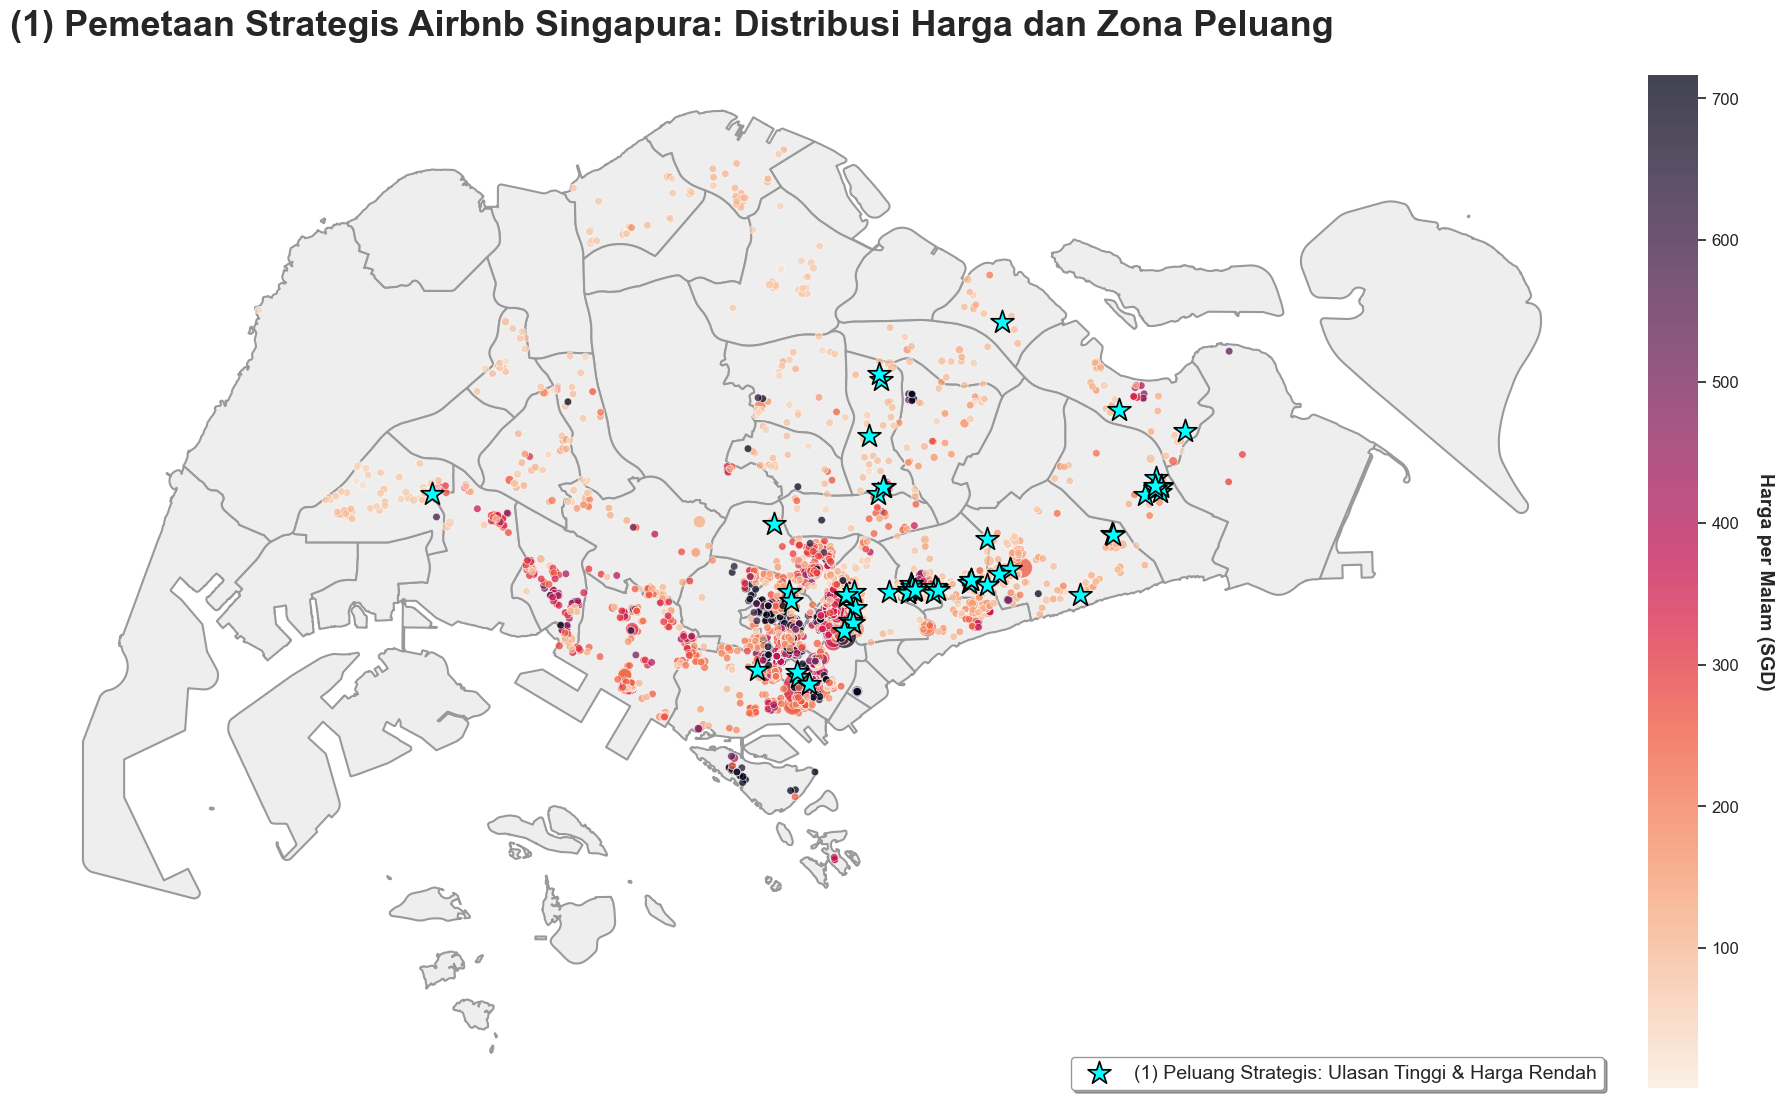

In [52]:
plt.figure(figsize=(18, 12))

ax = neighbourhoods_geo.plot(color='#eeeeee', edgecolor='#999999', linewidth=1.5, alpha=1, ax=plt.gca())

scatter = plt.scatter(listings_gz['longitude'], listings_gz['latitude'], 
            c=listings_gz['price_cleaned'], 
            cmap='rocket_r', 
            s=listings_gz['number_of_reviews'] * 0.5 + 30, 
            alpha=0.75, 
            edgecolors='white', linewidth=0.5)

price_threshold = listings_gz['price_cleaned'].quantile(0.25)
review_threshold = listings_gz['number_of_reviews'].quantile(0.95)
best_value = listings_gz[(listings_gz['price_cleaned'] <= price_threshold) & (listings_gz['number_of_reviews'] >= review_threshold)]

plt.scatter(best_value['longitude'], best_value['latitude'], 
            color='#00FFFF', s=300, marker='*', 
            label='(1) Peluang Strategis: Ulasan Tinggi & Harga Rendah',
            edgecolors='black', linewidth=1.2, zorder=10)

cbar = plt.colorbar(scatter, fraction=0.03, pad=0.02)
cbar.set_label('Harga per Malam (SGD)', rotation=270, labelpad=25, fontweight='bold', fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.outline.set_visible(False)

plt.title('(1) Pemetaan Strategis Airbnb Singapura: Distribusi Harga dan Zona Peluang', 
          fontsize=26, fontweight='bold', loc='left', pad=20)

plt.axis('off')

plt.legend(frameon=True, facecolor='white', framealpha=1, 
           loc='lower right', prop={'size': 14}, edgecolor='#999999', shadow=True)

plt.tight_layout()
plt.show()

#### i. **Interpretasi Pemetaan Strategis Airbnb**
**Analisis Visual**:
- Titik berwarna gelap mendominasi area tengah & selatan, menunjukkan akomodasi dengan harga lumayan banyak di sektor bisnis & pusat wisata utama.
- Sebaran di bagian Utara & barat cenderung lebih terang namun densitasnya rendah. Artinya aksesibilitas mungkin menjadi kendala bagi pertumbuhan listing di wilayah tersebut.
- Simbol bintang tersebar di sebagian daerah timur. Area itu memiliki karakteristik di mana harga rendah tapi ulasannya tinggi.

**Insight dari Plot**: Peta tersbut membuktikan lokasi adalah pnentu harga, namun ulasan adalah nilai. Akomodasi paling laris secara strategis bukan di pusat kota yang mahal, namun di wilayah yang cukup dekat dengan transum menuju pusat, tetapi biaya operasional memungkinkan harga yang kompetitif.

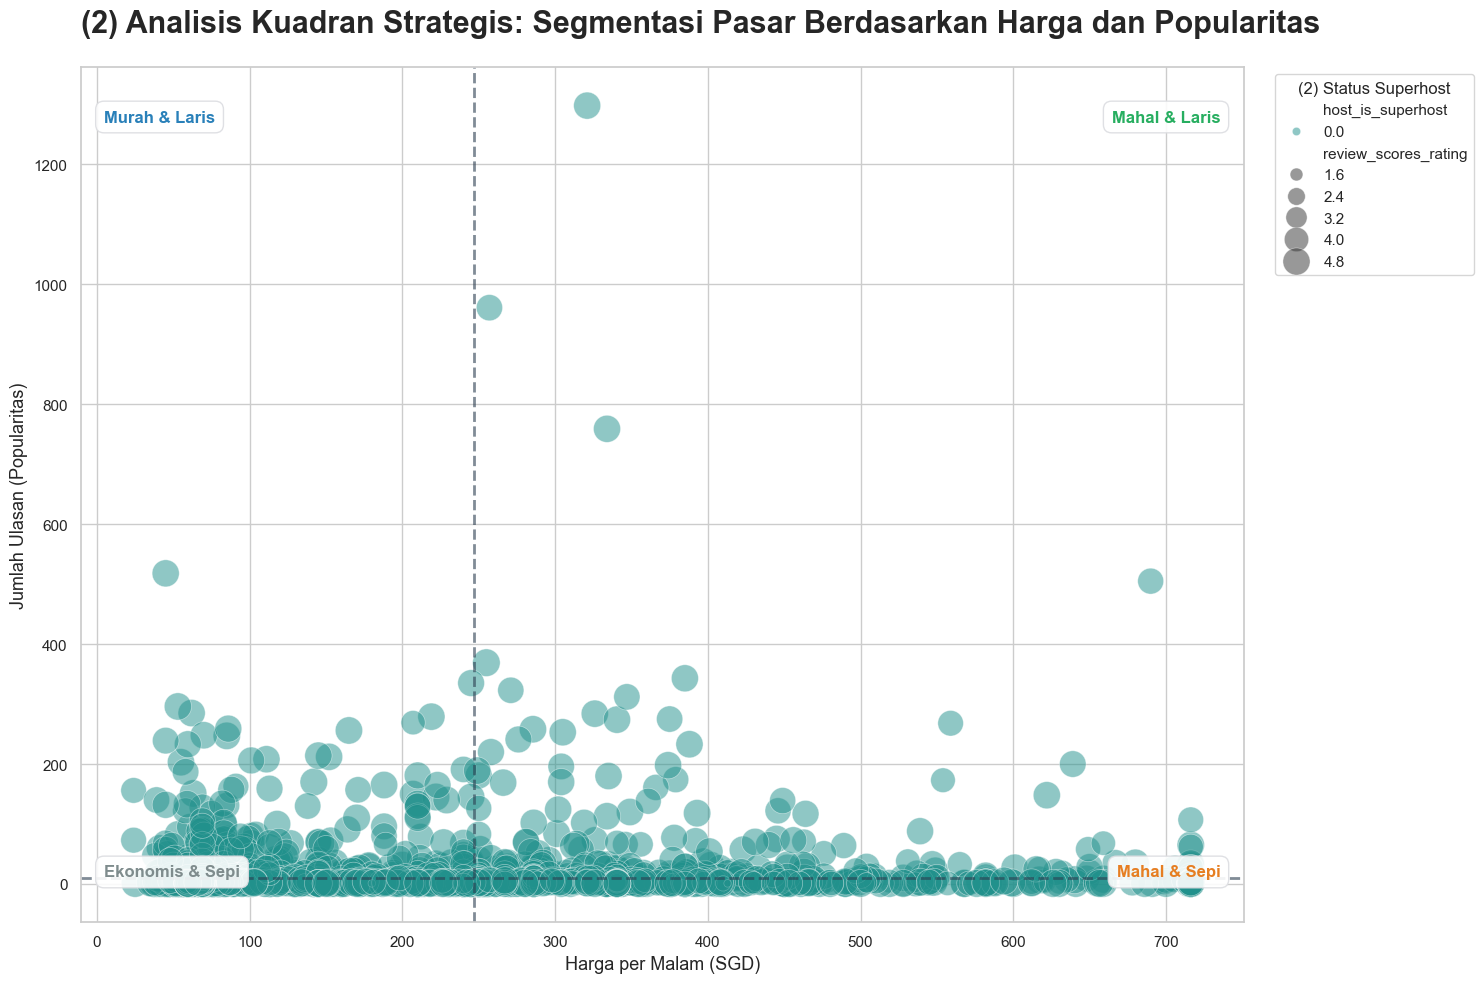

In [53]:
mean_price = listings_gz['price_cleaned'].mean()
mean_reviews = listings_gz['number_of_reviews'].mean()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

scatter = sns.scatterplot(
    data=listings_gz, 
    x='price_cleaned', 
    y='number_of_reviews', 
    hue='host_is_superhost', 
    size='review_scores_rating',
    sizes=(30, 400),
    palette='viridis', 
    alpha=0.5,
    edgecolor='white',
    linewidth=0.5
)

plt.axvline(mean_price, color='#2c3e50', linestyle='--', alpha=0.6, linewidth=2)
plt.axhline(mean_reviews, color='#2c3e50', linestyle='--', alpha=0.6, linewidth=2)

ax = plt.gca()
bbox_props = dict(boxstyle="round,pad=0.5", fc="#ffffff", ec="#dcdde1", alpha=0.9)

ax.text(0.02, 0.95, 'Murah & Laris', transform=ax.transAxes, 
        color='#2980b9', fontsize=12, weight='bold', bbox=bbox_props, va='top')

ax.text(0.98, 0.95, 'Mahal & Laris', transform=ax.transAxes, 
        color='#27ae60', fontsize=12, weight='bold', bbox=bbox_props, va='top', ha='right')

ax.text(0.02, 0.05, 'Ekonomis & Sepi', transform=ax.transAxes, 
        color='#7f8c8d', fontsize=12, weight='bold', bbox=bbox_props, va='bottom')

ax.text(0.98, 0.05, 'Mahal & Sepi', transform=ax.transAxes, 
        color='#e67e22', fontsize=12, weight='bold', bbox=bbox_props, va='bottom', ha='right')

plt.title('(2) Analisis Kuadran Strategis: Segmentasi Pasar Berdasarkan Harga dan Popularitas', 
          fontsize=22, fontweight='bold', loc='left', pad=25)
plt.xlabel('Harga per Malam (SGD)', fontsize=13)
plt.ylabel('Jumlah Ulasan (Popularitas)', fontsize=13)

plt.legend(title='(2) Status Superhost', bbox_to_anchor=(1.02, 1), 
           loc='upper left', frameon=True, prop={'size': 11})

plt.tight_layout()
plt.show()

#### ii. Interpretasi Plot Kuadran
**Analisis Visual**:
- Area di atas garis horizontal menunjukkan listing dg popularitas di atas rata-rata.
- Ekonomis & Sepi memiliki kepadatan tertinggi. Secara visual menunjukkan kompetisi antar pemilik listing karena mereka tidak memiliki keunggulan harga yang signifikan.
- Mahal & Sepi menunjukkan titik-titik tersebar jauh namun di bawah rata-rata ulasan yang berarti sangat tersegmentasi dan tidak bersifat massal.

**Insight dari Plot**:
Banyak pemilik listing mematok harga rendah tapi ulasannya sedikit. Stratgei yang efektif adalah menurunkan harga atau mengejar status superhost agar ukuran berpindah ke kuadran atas.

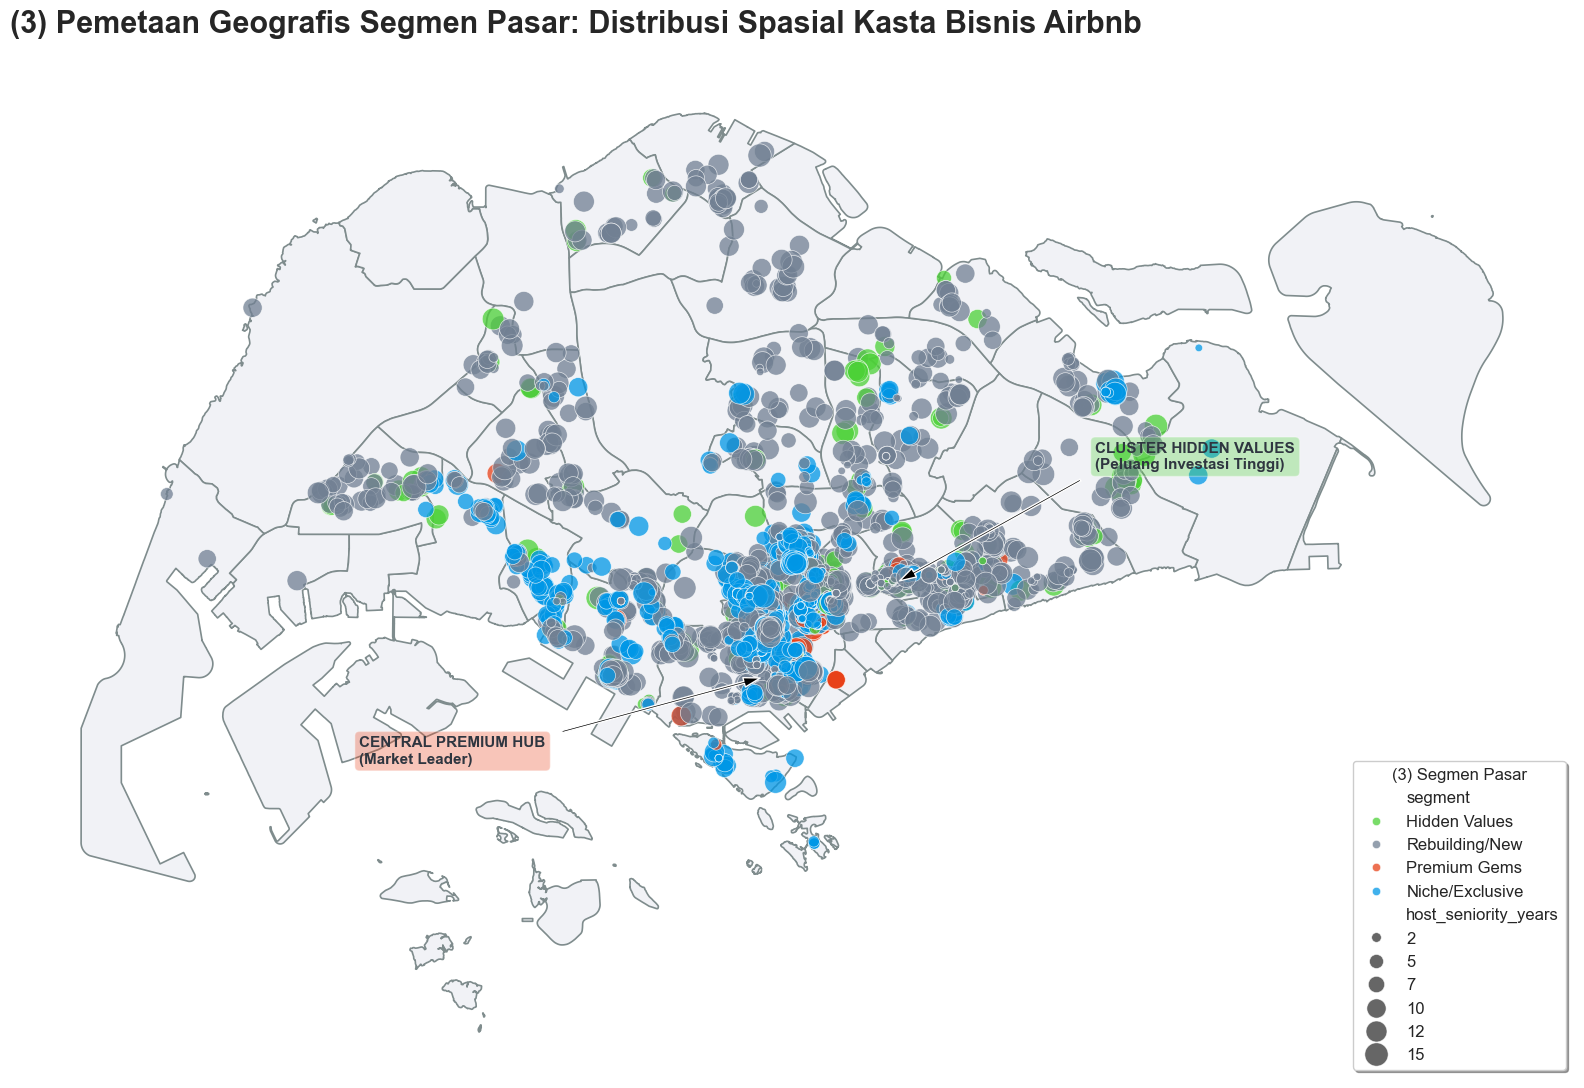

In [54]:
mean_price = listings_gz['price_cleaned'].mean()
mean_reviews = listings_gz['number_of_reviews'].mean()

def get_segment(row):
    if row['price_cleaned'] >= mean_price and row['number_of_reviews'] >= mean_reviews:
        return 'Premium Gems'
    elif row['price_cleaned'] < mean_price and row['number_of_reviews'] >= mean_reviews:
        return 'Hidden Values'
    elif row['price_cleaned'] >= mean_price and row['number_of_reviews'] < mean_reviews:
        return 'Niche/Exclusive'
    else:
        return 'Rebuilding/New'

listings_gz['segment'] = listings_gz.apply(get_segment, axis=1)

plt.figure(figsize=(16, 11))
sns.set_theme(style="white")

ax = neighbourhoods_geo.plot(color='#f1f2f6', edgecolor='#7f8c8d', linewidth=1.2, alpha=1, ax=plt.gca())

palette = {
    'Premium Gems': '#e84118',
    'Hidden Values': '#4cd137',
    'Niche/Exclusive': '#0097e6',
    'Rebuilding/New': '#718093'
}

sns.scatterplot(
    data=listings_gz, x='longitude', y='latitude', 
    hue='segment', palette=palette,
    size='host_seniority_years', sizes=(30, 300),
    alpha=0.75, edgecolor='w', linewidth=0.5, zorder=3
)

plt.annotate('CLUSTER HIDDEN VALUES\n(Peluang Investasi Tinggi)', 
             xy=(103.88, 1.31), xytext=(103.95, 1.35),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=7),
             fontsize=11, fontweight='bold', color='#2f3640', bbox=dict(boxstyle="round,pad=0.3", fc="#4cd137", alpha=0.3))

plt.annotate('CENTRAL PREMIUM HUB\n(Market Leader)', 
             xy=(103.84, 1.28), xytext=(103.70, 1.25),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=7),
             fontsize=11, fontweight='bold', color='#2f3640', bbox=dict(boxstyle="round,pad=0.3", fc="#e84118", alpha=0.3))

plt.title('(3) Pemetaan Geografis Segmen Pasar: Distribusi Spasial Kasta Bisnis Airbnb', 
          fontsize=22, fontweight='bold', loc='left', pad=25)

plt.legend(title='(3) Segmen Pasar', loc='lower right', prop={'size': 12}, 
           frameon=True, shadow=True, facecolor='white')

plt.axis('off')
plt.tight_layout()
plt.show()

#### iii. Interpretasi Segmentasi Pasar Geografis:
**Analisis Visual**:
- Klaster Hijau terkonsentrasi di timur pusat kota. Klaster Merah di inti kota.

**Insight**:
- Ada segmentasi wilayah yang jelas. Investor harus memilih untuk bermain di kepadatan tinggi margin rendah (timur) atau margin tinggi kepadatan rendah (pusat).

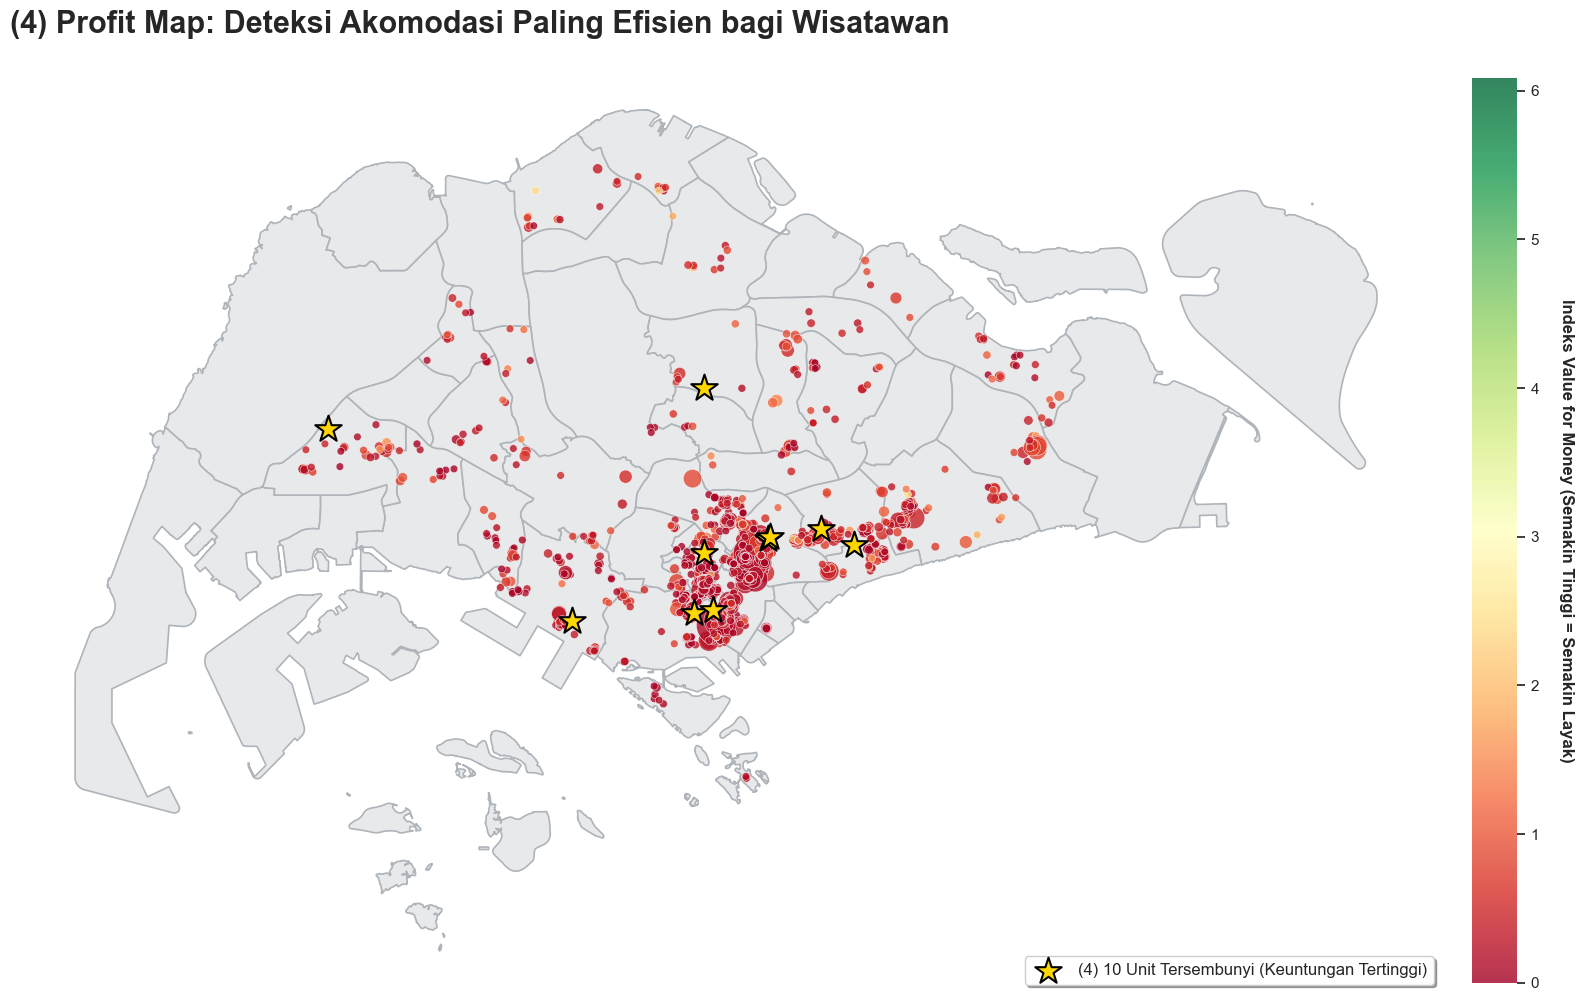

In [55]:
rev_agg = reviews_gz.groupby('listing_id')['review_length'].mean().reset_index()
df_unt = listings_gz.merge(rev_agg, left_on='id', right_on='listing_id', how='left')

df_unt['norm_rating'] = df_unt['review_scores_rating'] / 5.0
df_unt['norm_length'] = (df_unt['review_length'] - df_unt['review_length'].min()) / \
                        (df_unt['review_length'].max() - df_unt['review_length'].min())
df_unt['norm_price'] = (df_unt['price_cleaned'] - df_unt['price_cleaned'].min()) / \
                       (df_unt['price_cleaned'].max() - df_unt['price_cleaned'].min())

df_unt['unt_index'] = (df_unt['norm_rating'] * df_unt['norm_length']) / (df_unt['norm_price'] + 0.1)

plt.figure(figsize=(16, 11))
sns.set_theme(style="white")

ax = neighbourhoods_geo.plot(color='#e8e9ea', edgecolor='#aeb4ba', linewidth=1.2, ax=plt.gca())

scatter = plt.scatter(df_unt['longitude'], df_unt['latitude'],
            c=df_unt['unt_index'], cmap='RdYlGn',
            s=df_unt['number_of_reviews'] * 0.6 + 30,
            alpha=0.8, edgecolors='white', linewidth=0.4, zorder=3)

champions = df_unt.nlargest(10, 'unt_index')
plt.scatter(champions['longitude'], champions['latitude'], 
            color='gold', s=400, marker='*', edgecolors='black', 
            linewidth=1.5, label='(4) 10 Unit Tersembunyi (Keuntungan Tertinggi)', zorder=5)

cbar = plt.colorbar(scatter, fraction=0.03, pad=0.02)
cbar.set_label('Indeks Value for Money (Semakin Tinggi = Semakin Layak)', 
               rotation=270, labelpad=25, fontweight='bold', fontsize=12)
cbar.outline.set_visible(False)

plt.title('(4) Profit Map: Deteksi Akomodasi Paling Efisien bagi Wisatawan', 
          fontsize=22, fontweight='bold', loc='left', pad=25)

plt.legend(loc='lower right', prop={'size': 12}, frameon=True, shadow=True)
plt.axis('off')
plt.tight_layout()
plt.show()

#### iv. Interpretasi Peta Profit:
**Analisis Visual**:
- Indeks Keuntungan menujukkan bahwa properti palin efisien tidak murah, tapi yang memberikan fasilitas terbaik dengan harga terjagkau.

**Insight**:
- Tamu bersedia membayar sedikit lebih mahal asaal ada kualitas.

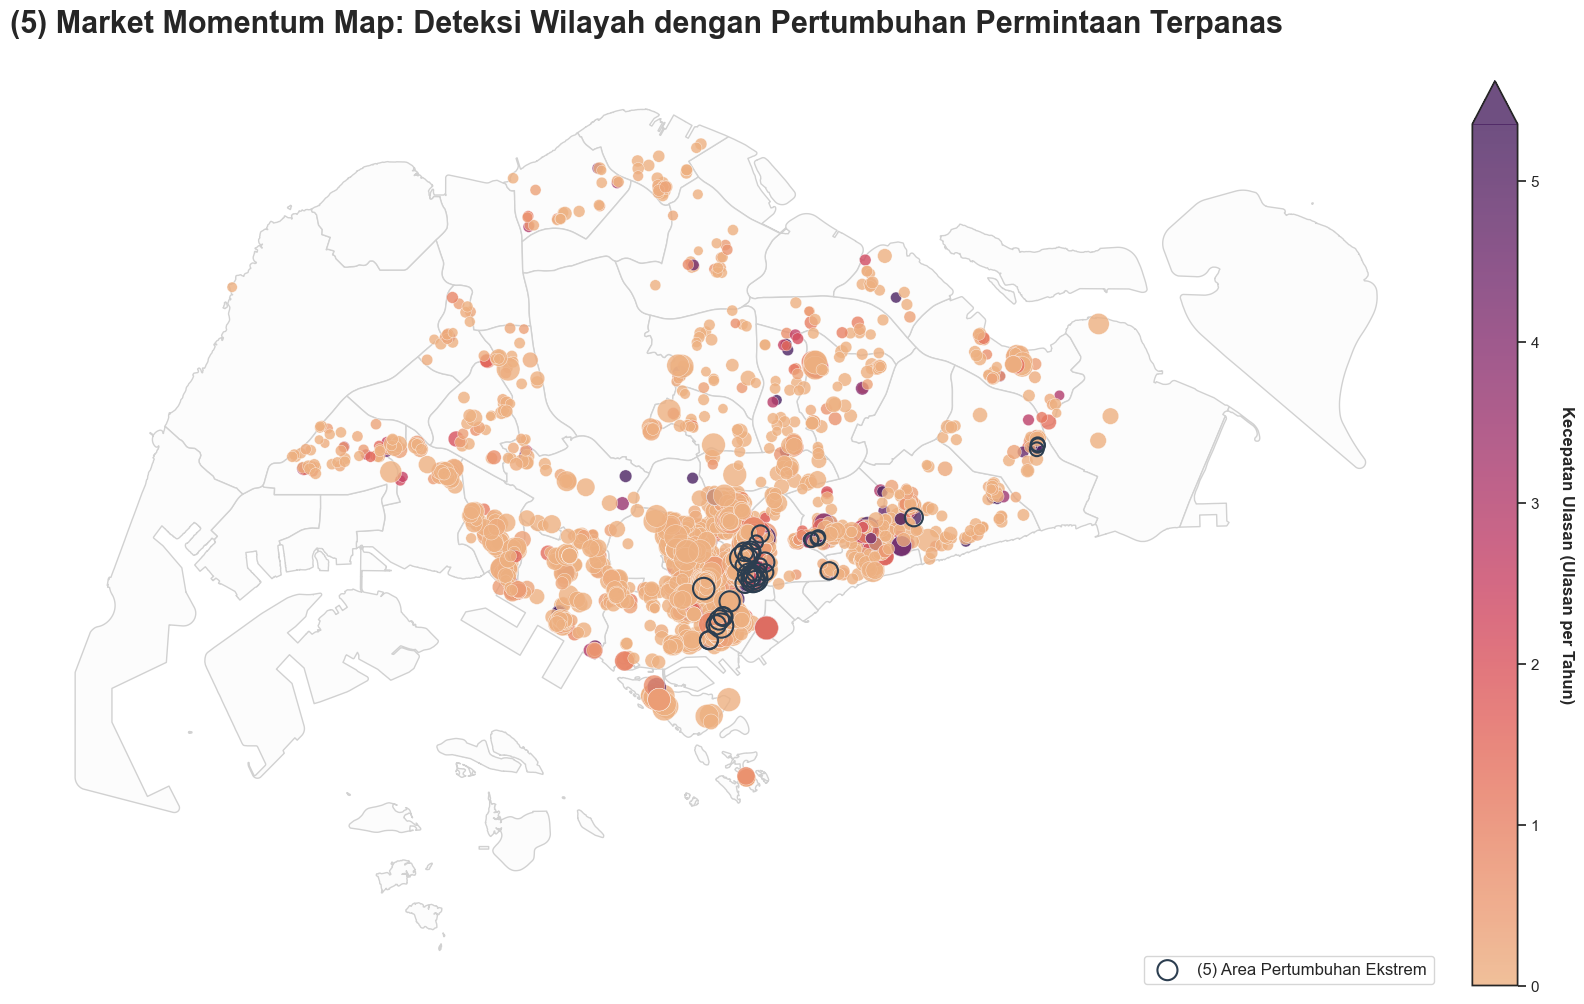

In [56]:
listings_gz['review_velocity'] = listings_gz['number_of_reviews'] / (listings_gz['host_seniority_years'] + 1)

plt.figure(figsize=(16, 11))
sns.set_theme(style="white")

ax = neighbourhoods_geo.plot(color='#fcfcfc', edgecolor='#d1d1d1', linewidth=1, ax=plt.gca())

v_max = listings_gz['review_velocity'].quantile(0.95)
scatter = plt.scatter(listings_gz['longitude'], listings_gz['latitude'],
            c=listings_gz['review_velocity'], 
            cmap='flare', 
            vmin=0, vmax=v_max,
            s=listings_gz['price_scaled'] * 250 + 40,
            alpha=0.8, edgecolors='white', linewidth=0.3, zorder=3)

top_1_percent = listings_gz[listings_gz['review_velocity'] >= listings_gz['review_velocity'].quantile(0.99)]

plt.scatter(top_1_percent['longitude'], top_1_percent['latitude'], 
            color='none', 
            edgecolors='#2c3e50', 
            s=top_1_percent['price_scaled'] * 250 + 80,
            linewidth=1.5, zorder=4, 
            label='(5) Area Pertumbuhan Ekstrem')

cbar = plt.colorbar(scatter, fraction=0.03, pad=0.02, extend='max')
cbar.set_label('Kecepatan Ulasan (Ulasan per Tahun)', rotation=270, labelpad=25, fontweight='bold')

plt.title('(5) Market Momentum Map: Deteksi Wilayah dengan Pertumbuhan Permintaan Terpanas', 
          fontsize=22, fontweight='bold', loc='left', pad=25)

plt.legend(loc='lower right', frameon=True, prop={'size': 12})
plt.axis('off')
plt.tight_layout()
plt.show()

#### v. Interpretasi Momen Pasar:
**Analisis Visual**:
- Area dengan pertumbuhan ulasan tercepat ada di pinggiran pusat kota, ukuran titik menunjukkan harga bervariasi.

**Insight**:
- Permintaan bergeser ke area yang lebih residensial, bukan sekedar area turis.

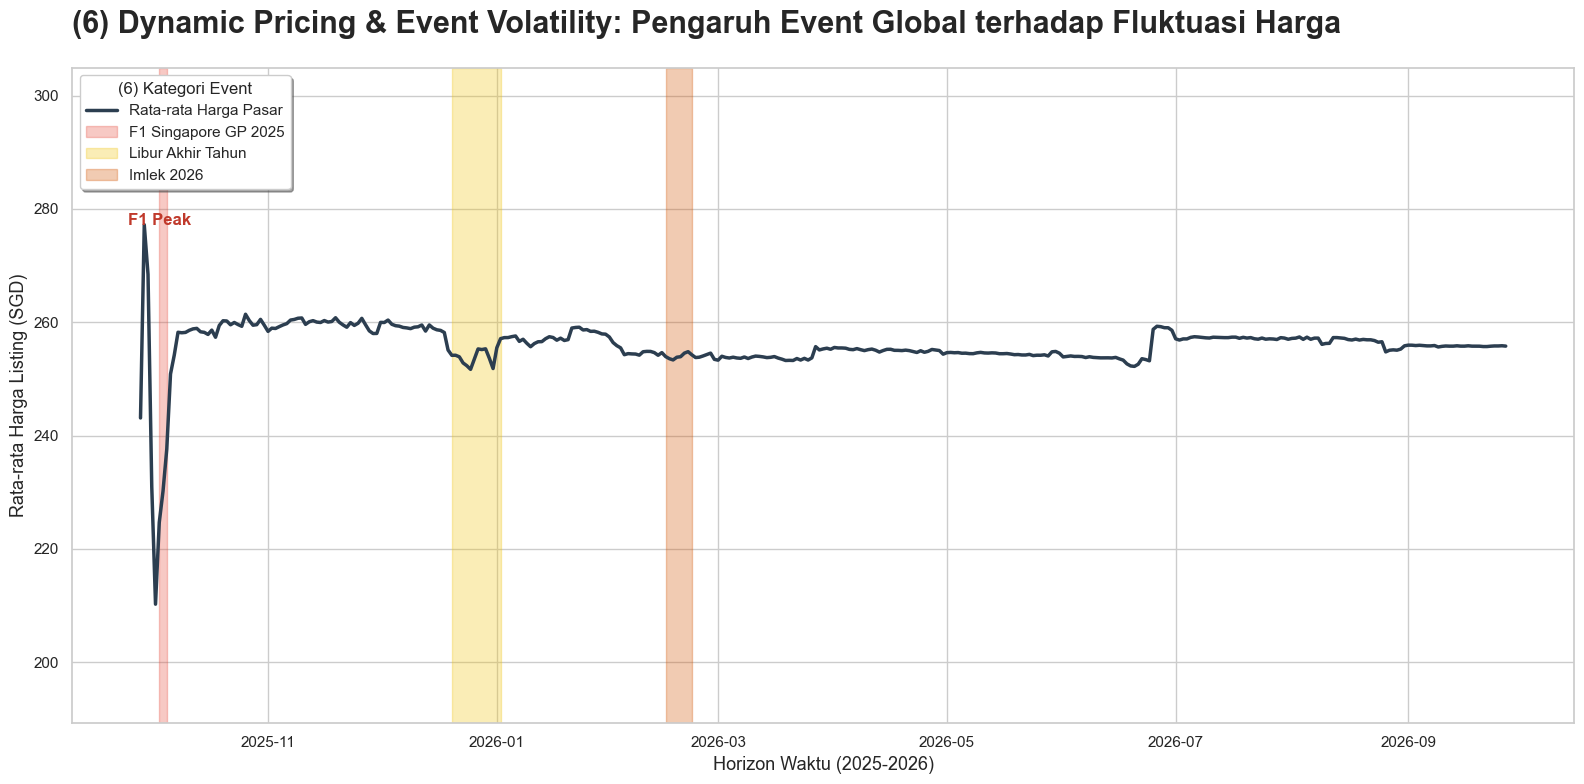

In [57]:
daily_avg = calendar_gz.groupby('date')['price_final'].mean().reset_index()
plt.figure(figsize=(16, 8))
sns.set_theme(style="whitegrid")

sns.lineplot(data=daily_avg, x='date', y='price_final', color='#2c3e50', linewidth=2.5, label='Rata-rata Harga Pasar')

f1_start, f1_end = pd.Timestamp('2025-10-03'), pd.Timestamp('2025-10-05')
plt.axvspan(f1_start, f1_end, color='#e74c3c', alpha=0.3, label='F1 Singapore GP 2025')
plt.text(f1_start, daily_avg['price_final'].max(), 'F1 Peak', color='#c0392b', fontweight='bold', ha='center')

h_start, h_end = pd.Timestamp('2025-12-20'), pd.Timestamp('2026-01-02')
plt.axvspan(h_start, h_end, color='#f1c40f', alpha=0.3, label='Libur Akhir Tahun')

lny_start, lny_end = pd.Timestamp('2026-02-15'), pd.Timestamp('2026-02-22')
plt.axvspan(lny_start, lny_end, color='#d35400', alpha=0.3, label='Imlek 2026')

plt.title('(6) Dynamic Pricing & Event Volatility: Pengaruh Event Global terhadap Fluktuasi Harga', 
          fontsize=22, fontweight='bold', loc='left', pad=25)
plt.xlabel('Horizon Waktu (2025-2026)', fontsize=13)
plt.ylabel('Rata-rata Harga Listing (SGD)', fontsize=13)

plt.legend(title='(6) Kategori Event', loc='upper left', frameon=True, shadow=True)
plt.ylim(daily_avg['price_final'].min() * 0.9, daily_avg['price_final'].max() * 1.1)
plt.tight_layout()

plt.show()

#### vi. Interpretasi Dinamika Pricing:
**Analisis Visual**:
- Grafik garis menunjukkan lonjakan tajam saat event F1.

**Insight**:
- Host di singapura sangat proaktif, menjadikan komponen periode event sebagai pendapatan yang harus dimaksimalkan.

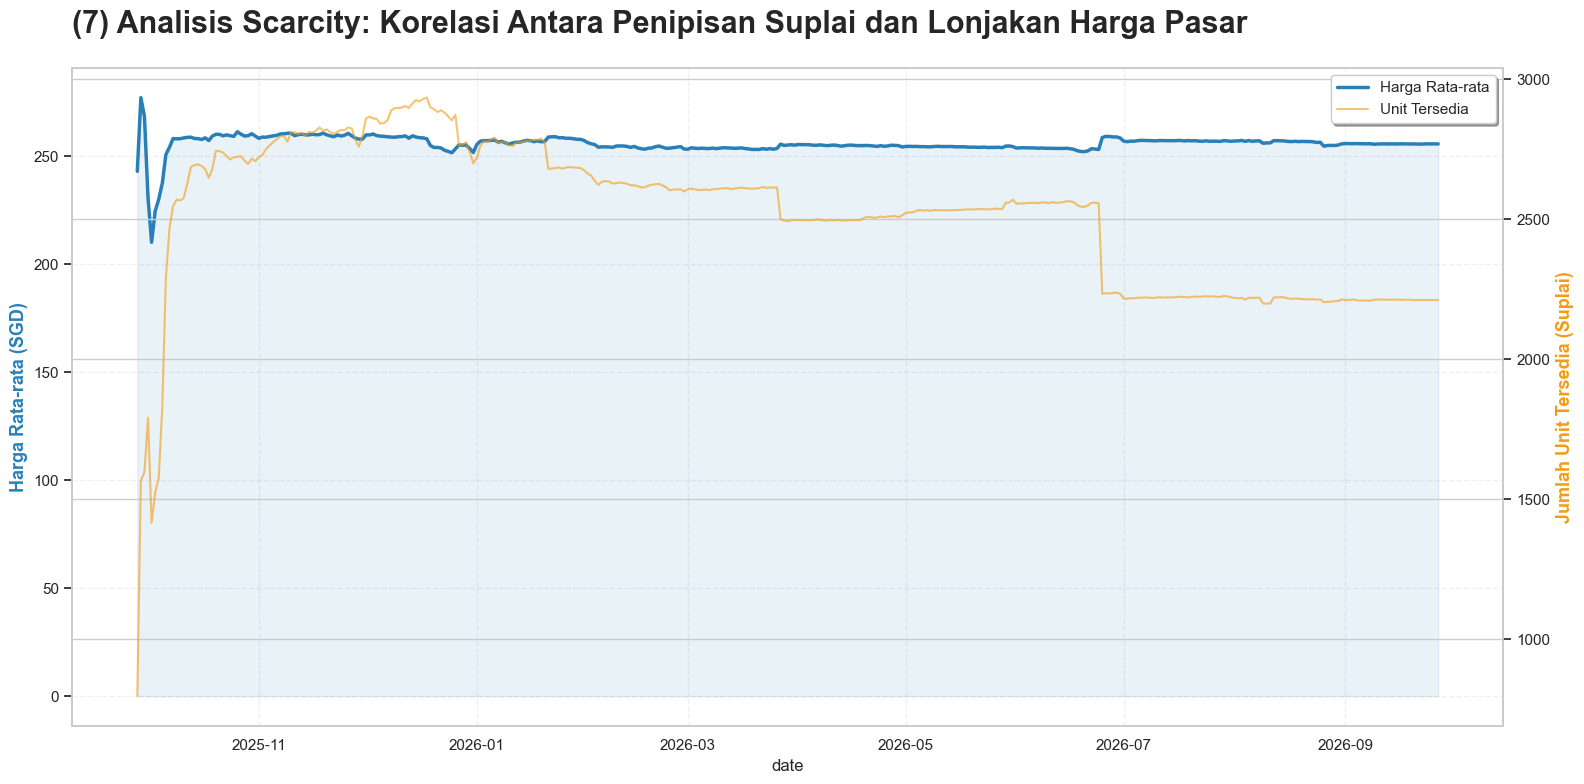

In [58]:
df_merged = calendar_gz.merge(listings_gz[['id', 'neighbourhood_group_cleansed']], left_on='listing_id', right_on='id')
supply_price = calendar_gz.groupby('date').agg(
    avg_price=('price_final', 'mean'),
    available_units=('listing_id', 'count')
).reset_index()

plt.figure(figsize=(16, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

sns.lineplot(data=supply_price, x='date', y='avg_price', ax=ax1, color='#2980b9', linewidth=2.5, label='Harga Rata-rata')
sns.lineplot(data=supply_price, x='date', y='available_units', ax=ax2, color='#f39c12', linewidth=1.5, alpha=0.6, label='Unit Tersedia')

ax1.fill_between(supply_price['date'], supply_price['avg_price'], alpha=0.1, color='#2980b9')
ax1.set_ylabel('Harga Rata-rata (SGD)', color='#2980b9', fontsize=13, fontweight='bold')
ax2.set_ylabel('Jumlah Unit Tersedia (Suplai)', color='#f39c12', fontsize=13, fontweight='bold')

plt.title('(7) Analisis Scarcity: Korelasi Antara Penipisan Suplai dan Lonjakan Harga Pasar', 
          fontsize=22, fontweight='bold', loc='left', pad=25)

ax1.grid(True, linestyle='--', alpha=0.3)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', frameon=True, shadow=True)

plt.tight_layout()
plt.show()

#### vii. Interpretasi Segmentasi Pasar Geografis:
**Analisis Visual**:
- Ada korelasi negatif saat jumlah unit tersedia turun, dan harga rata-rata naik.

**Insight**:
- Kelangkaan adalah penggerak harga utama, suplai menipis.

### 2. Analisis dalam Tabel

In [59]:
rev_agg = reviews_gz.groupby('listing_id')['review_length'].mean().reset_index()
df_vfm = listings_gz.merge(rev_agg, left_on='id', right_on='listing_id', how='left')
df_vfm['review_length'] = df_vfm['review_length'].fillna(0)

df_vfm['norm_rating'] = df_vfm['review_scores_rating'].fillna(0) / 5.0
df_vfm['norm_length'] = (df_vfm['review_length'] - df_vfm['review_length'].min()) / \
                        (df_vfm['review_length'].max() - df_vfm['review_length'].min() + 1e-9)
df_vfm['norm_price'] = (df_vfm['price_cleaned'] - df_vfm['price_cleaned'].min()) / \
                       (df_vfm['price_cleaned'].max() - df_vfm['price_cleaned'].min() + 1e-9)

df_vfm['vfm_index'] = (df_vfm['norm_rating'] * df_vfm['norm_length']) / (df_vfm['norm_price'] + 0.1)
df_vfm['review_velocity'] = df_vfm['number_of_reviews'] / (df_vfm['host_seniority_years'] + 1)

table1 = df_vfm.groupby('segment').agg(
    listing_count=('id', 'count'),
    avg_price=('price_cleaned', 'mean'),
    avg_rating=('review_scores_rating', 'mean'),
    avg_velocity=('review_velocity', 'mean'),
    avg_vfm_index=('vfm_index', 'mean')
).round(3).sort_values(by='avg_vfm_index', ascending=False)

table1.columns = ['Jumlah Listing', 'Rata-rata Harga (SGD)', 'Rating Rata-rata', 'Momentum (Rev/Thn)', 'VFM Index']
display(table1)

,Jumlah Listing,Rata-rata Harga (SGD),Rating Rata-rata,Momentum (Rev/Thn),VFM Index
segment,,,,,
Hidden Values,305,123.289,4.632,6.472,0.530
Rebuilding/New,1807,123.398,4.488,0.179,0.225
Premium Gems,236,414.553,4.608,8.267,0.191
Niche/Exclusive,1345,410.850,4.499,0.208,0.064


#### i. Interpretasi Profil Segmen:
- Segmen Hidden Value menjadi pertumbuhan utama, menunjukkan bahwa singapura mampu menyeimbangkan harga dengan layanan yang bagus.
- Segmen premium gems mempertahankan rating rataan yang tinggi dengan harga premium.

In [60]:
price_map = listings_gz.set_index('id')['price_cleaned'].to_dict()
calendar_gz['price_final'] = calendar_gz['listing_id'].map(price_map)

calendar_avail = calendar_gz[calendar_gz['available'] == 't'].copy()
calendar_avail['date'] = pd.to_datetime(calendar_avail['date'])

events = {
    'F1 Singapore GP': ('2025-10-03', '2025-10-05'),
    'Year-End Holidays': ('2025-12-20', '2026-01-02'),
    'Lunar New Year 2026': ('2026-02-15', '2026-02-22'),
    'Baseline (Overall)': (calendar_avail['date'].min(), calendar_avail['date'].max())
}

event_summary = []
for event_name, (start, end) in events.items():
    mask = (calendar_avail['date'] >= pd.to_datetime(start)) & (calendar_avail['date'] <= pd.to_datetime(end))
    subset = calendar_avail[mask]
    
    if not subset.empty:
        daily_supply = subset.groupby('date')['listing_id'].count().mean()
        event_summary.append({
            'Event Period': event_name,
            'Avg Price (SGD)': subset['price_final'].mean(),
            'Avg Available Units': round(daily_supply, 0)
        })

table2 = pd.DataFrame(event_summary).round(2)
display(table2)

,Event Period,Avg Price (SGD),Avg Available Units
0,F1 Singapore GP,231.23,1645.0
1,Year-End Holidays,254.02,2812.0
2,Lunar New Year 2026,254.03,2620.0
3,Baseline (Overall),256.05,2516.0


#### ii. Interpretasi Dampak Event Temporal:
- Pendapatan tahunan seorang host bergantung dari 5%-10% hari di kalender acara, di mana harga pasar tidak dipengaruhi properti, tapi ketersediaan unit di pasar.

## E. Ringkasan & Kesimpulan
### 1. Temuan Utama
- Dominasi Geografi Nilai (Value-Driven Geography): Lokasi di pusat kota (CBD) memang menguasai harga tertinggi, namun wilayah seperti Geylang dan Kallang muncul sebagai zona pertumbuhan paling sehat. Wilayah ini menawarkan indeks keuntungan terbaik, yang membuktikan bahwa tamu di Singapura sangat rasional dalam menyeimbangkan antara harga lumayan dan kualitas ulasan.
- Efek Supply Shock pada Event Global: Kalender event dunia, khususnya F1 Singapore GP, menjadi penggerak anomali harga terbesar. Data menunjukkan terjadinya fenomena kelangkaan (scarcity) di mana penurunan drastis pada unit tersedia memaksa harga pasar meroket secara non-linear. Hal ini menunjukkan bahwa pasar Airbnb Singapura sangat efisien dan responsif terhadap dinamika permintaan global.
- Segmentasi Pasar yang Brutal: Keberhasilan terkonsentrasi pada dua kutub: Hidden Values (murah namun memiliki ulasan besar) dan Premium Gems (mahal namun memiliki reputasi superhost). Listing yang berada di tengah tanpa karakter yang jelas cenderung terjebak dalam segmen Rebuilding/New dengan tingkat hunian yang rendah.
### 2. Keterbatasan
- Keterbatasan Proksi Kualitas: Penggunaan panjang karakter ulasan (review length) sebagai kualitas hanya bersifat teknis. Analisis ini belum membedakan secara semantik antara ulasan panjang yang bersifat keluhan dengan ulasan panjang yang bersifat pujian.
- Variabel Biaya Operasional: Data yang diolah adalah pendapatan kotor (gross revenue). Kami tidak memiliki akses ke data biaya operasional host (pajak, listrik, biaya cleaning), sehingga margin keuntungan bersih yang sebenarnya tidak dapat diketahui secara pasti.
- Regulasi yang Dinamis: Analisis mengasumsikan kebijakan pemerintah Singapura terhadap penyewaan jangka pendek bersifat statis, padahal perubahan regulasi mendadak dapat secara signifikan mengubah struktur suplai di masa depan.
### 3. Saran Pengembangan
- Analisis Sentimen (NLP): Menggunakan Natural Language Processing (NLP) untuk membedah emosi dalam ulasan tamu guna memberikan skor kepuasan yang lebih akurat dibandingkan sekadar menghitung panjang teks.
= Model Prediksi Okupansi: Membangun model Machine Learning untuk memprediksi probabilitas sebuah unit dipesan pada tanggal tertentu, sehingga host dapat melakukan optimasi harga secara otomatis sebelum periode high-season.
- Analisis Kedekatan MRT: Menghitung jarak spasial setiap listing ke stasiun MRT terdekat sebagai variabel tambahan, mengingat mobilitas publik adalah faktor krusial dalam pemilihan akomodasi di Singapura.